In [115]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding
from openTSNE.affinity import Affinities

import time
import pickle

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [116]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.plotting import (
    improved_coloring,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [118]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")
data_path = Path("../data")

In [119]:
plt.style.use("matplotlib_style.txt")

Pipeline from raw text to two dimensional embedding

# Import

In [216]:
# import clean_df_updated
clean_df_updated_reparsed_filtered_with_authors_ISSN = pd.read_pickle(
    berenslab_data_path
    / "clean_df_updated_reparsed_filtered_with_authors_ISSN"
)

tcmalloc: large alloc 1073741824 bytes == 0x9a62ea000 @ 
tcmalloc: large alloc 1233903616 bytes == 0xa5027c000 @ 
tcmalloc: large alloc 2147483648 bytes == 0xa99b3a000 @ 
tcmalloc: large alloc 1542381568 bytes == 0x9a62ea000 @ 
tcmalloc: large alloc 1927979008 bytes == 0xa15518000 @ 


In [217]:
clean_df_updated_reparsed_filtered_with_authors_ISSN.head()

,PMID,Title,AbstractText,Language,Journal,Date,NameFirstAuthor,NameLastAuthor,ISSN,filename
0,1133452,Reflections on the special senses in relation ...,"In congenital blindness, the absence of vision...",eng,Journal of the American Psychoanalytic Associa...,1975,H R,H R,0003-0651,pubmed21n0038.xml
1,1133453,Tracing a memory.,Comparisons of the nests of associations withi...,eng,Journal of the American Psychoanalytic Associa...,1975,K H,K H,0003-0651,pubmed21n0038.xml
2,1133454,Some pitfalls in the assessment of analyzabili...,We have described some of the problems encount...,eng,Journal of the American Psychoanalytic Associa...,1975,H,P,0003-0651,pubmed21n0038.xml
3,1133455,"Variability of the iron, copper and mercury co...","The relative iron, copper and mercury contents...",eng,The journal of histochemistry and cytochemistr...,1975 May,J R,R S,0022-1554,pubmed21n0038.xml
4,1133526,"Hypophysectomy of the tammar wallaby, Macropus...",A technique of hypophysectomy and regimes of p...,eng,The Journal of endocrinology,1975 Mar,J P,J P,0022-0795,pubmed21n0038.xml


In [46]:
%%time
%%memit
embeddings_reparsed_all = np.load(
    berenslab_data_path / "embeddings/embeddings_reparsed_all.npy"
)

tcmalloc: large alloc 127101853696 bytes == 0x9aae38000 @ 


peak memory: 173961.65 MiB, increment: 119284.82 MiB
CPU times: user 642 ms, sys: 1min, total: 1min 1s
Wall time: 1min 44s


In [5]:
# load
# legend colors
pickle_in = open(
    "../../pubmed-landscape/results/variables/colors_new_legend.pkl", "rb"
)
colors_new_legend = pickle.load(pickle_in)

colors_new = np.load(
    "../../pubmed-landscape/results/variables/colors_new.npy",
    allow_pickle=True,
)

## Subset

In [22]:
np.random.seed(42)
subset = np.random.choice(
    np.sum([colors_new != "lightgrey"]),
    size=16000,
    replace=False,
)

In [23]:
abstracts_subset = (
    clean_df_updated_reparsed_filtered_with_authors_ISSN.AbstractText[
        colors_new != "lightgrey"
    ].iloc[subset]
)

In [47]:
embeddings_subset = embeddings_reparsed_all[colors_new != "lightgrey"][subset]

tcmalloc: large alloc 43768053760 bytes == 0x27ca3fe000 @ 


In [24]:
colors_subset = colors_new[colors_new != "lightgrey"][subset]

## Subset Dmitry

In [7]:
np.random.seed(42)
subset = np.random.choice(
    np.sum([colors_new != "lightgrey"]),
    size=10000,
    replace=False,
)

In [8]:
abstracts_subset = (
    clean_df_updated_reparsed_filtered_with_authors_ISSN.AbstractText[
        colors_new != "lightgrey"
    ].iloc[subset]
)

In [11]:
abstracts_subset = abstracts_subset.to_numpy()

In [9]:
colors_subset = colors_new[colors_new != "lightgrey"][subset]

In [12]:
np.save(variables_path / "abstracts_subset_10k", abstracts_subset)
np.save(variables_path / "colors_subset_10k", colors_subset)

# TF-IDF Vectorizer

In [25]:
%%time
%%memit

# TfidfVectorizer
corpus = abstracts_subset.tolist()
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_subset = vectorizer.fit_transform(corpus)

peak memory: 54685.34 MiB, increment: 11.19 MiB
CPU times: user 2.16 s, sys: 1.75 s, total: 3.92 s
Wall time: 3.92 s


In [26]:
print(tfidf_subset.shape)

(16000, 77086)


In [27]:
# save results
sp.sparse.save_npz(variables_path / "tfidf_subset", tfidf_subset)

# Truncated SVD

In [28]:
%%time
%%memit

# TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42, algorithm="arpack")
svd_data_subset = svd.fit_transform(tfidf_subset)

# save results
# np.save(variables_path / "svd_data_subset", svd_data_subset)

peak memory: 54687.77 MiB, increment: 4.86 MiB
CPU times: user 1min 8s, sys: 3min 4s, total: 4min 13s
Wall time: 5.58 s


# t-SNE

Annealing exgg=1, n_iter=2000 

In [29]:
def run_tsne(
    embeddings, model_name, variables_path, rs=42, save_intermediates=True
):
    # affinities
    A = affinity.Uniform(
        embeddings,
        k_neighbors=10,
        n_jobs=-1,
        verbose=1,
        random_state=42,
    )

    # initialization
    I = initialization.pca(embeddings, random_state=42)

    if save_intermediates == True:
        affinities_name = "affinities_P_" + model_name
        sp.sparse.save_npz(variables_path / affinities_name, A.P)

        initialization_name = "initialization_" + model_name
        np.save(variables_path / initialization_name, I)

    # t-SNE optimization
    E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

    ## early exaggeration
    E = E.optimize(
        n_iter=125, exaggeration=12, momentum=0.5, n_jobs=-1, verbose=True
    )

    ## exaggeration annealing
    exs = np.linspace(12, 1, 125)
    for i in range(125):
        E = E.optimize(
            n_iter=1,
            exaggeration=exs[i],
            momentum=0.8,
            n_jobs=-1,
            verbose=True,
        )

    ## final optimization without exaggeration
    E = E.optimize(
        n_iter=500, exaggeration=1, momentum=0.8, n_jobs=-1, verbose=True
    )

    tsne = np.array(E)

    # save
    tsne_name = "tsne_" + model_name
    np.save(variables_path / tsne_name, tsne)

    return tsne

## TF-IDF t-SNE

In [30]:
%%time
tsne_tfidf_subset = run_tsne(
    svd_data_subset,
    "tfidf_subset",
    variables_path,
    rs=42,
    save_intermediates=False,
)

===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 4.47 seconds
===> Running optimization with exaggeration=12.00, lr=1333.33 for 125 iterations...
Iteration   50, KL divergence 6.6651, 50 iterations in 1.8970 sec
Iteration  100, KL divergence 6.4375, 50 iterations in 1.8895 sec
   --> Time elapsed: 4.64 seconds
===> Running optimization with exaggeration=12.00, lr=1333.33 for 1 iterations...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=11.91, lr=1333.33 for 1 iterations...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=11.82, lr=1333.33 for 1 iterations...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=11.73, lr=1333.33 for 1 iterations...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=11.65, lr=1333.33 for 1 iterations...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration

## BERT t-SNE

In [48]:
%%time
tsne_bert_subset = run_tsne(
    embeddings_subset,
    "bert_subset",
    variables_path,
    rs=42,
    save_intermediates=False,
)

===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 5.82 seconds
===> Running optimization with exaggeration=12.00, lr=1333.33 for 125 iterations...
Iteration   50, KL divergence 6.6283, 50 iterations in 1.6509 sec
Iteration  100, KL divergence 6.4287, 50 iterations in 1.7169 sec
   --> Time elapsed: 4.22 seconds
===> Running optimization with exaggeration=12.00, lr=1333.33 for 1 iterations...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=11.91, lr=1333.33 for 1 iterations...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=11.82, lr=1333.33 for 1 iterations...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=11.73, lr=1333.33 for 1 iterations...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=11.65, lr=1333.33 for 1 iterations...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration

# Plot

## Function

In [44]:
def plot_tsne_colors(
    tsne, colors, x_lim, y_lim, ax=None, plot_type=None, axis_on=False
):
    """Plot t-SNE embedding with colors (by labels).

    Parameters
    ----------
    tsne: array-like
        t-SNE coordinates.
    colors : array-like
        Color values for the colormap.
    x_lim : tuple (left, right)
        Limits of the x-axis.
    y_lim : tuple (bottom, top)
        Limits of the y-axis.
    ax : axes, optional
        Axes where to draw the figure. If ax=None, axes will be created.
    plot_type : {None, 'subplot_2', 'subplot_3', 'subplot_3_grey', 'subregion', 'test'}, default=None
        Style of the plot, modifies dotsize and alpha.
    axis_on : bool, default=False
        If True, axis is shown in plot.

    """
    if (x_lim, y_lim) != (None, None):
        assert x_lim[0] < x_lim[1], "xlim values are in the wrong order."
        assert y_lim[0] < y_lim[1], "ylim values are in the wrong order."

    assert plot_type in [
        None,
        "subplot_2",
        "subplot_3",
        "subplot_3_grey",
        "subregion",
        "test",
        "pdf ML",
    ], "Not valid `plot_type` value. Choose from [None, 'subplot_2', 'subplot_3', 'subplot_3_grey', 'subregion', 'test', 'pdf ML']."

    if ax is None:
        fig, ax = plt.subplots()

    s_grey = 0.1
    s_color = 0.5
    alpha_grey = 0.2
    alpha_color = 0.2

    if plot_type == "subplot_2":
        s_grey = 0.2
        s_color = 0.2

    if plot_type == "subplot_3":
        s_grey = 0.1
        s_color = 0.1

    if plot_type == "subplot_3_grey":
        s_grey = 0.05
        alpha_grey = 0.01
        s_color = 0.2
        alpha_color = 0.5

    if plot_type == "subregion":
        s_grey = 1
        s_color = 1
        alpha_grey = 0.6
        alpha_color = 0.7

    if plot_type == "test":
        s_grey = 3
        s_color = 3
        alpha_grey = 0.6
        alpha_color = 0.7

    if plot_type == "pdf ML":
        s_grey = 0.5
        alpha_grey = 0.02

        # s_grey = 0.2
        # alpha_grey = 0.2
        s_color = 0.2
        alpha_color = 0.5

    ax.scatter(
        tsne[:, 0][colors == "lightgrey"],
        tsne[:, 1][colors == "lightgrey"],
        s=s_grey,
        alpha=alpha_grey,
        c="lightgrey",
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )
    ax.scatter(
        tsne[:, 0][colors != "lightgrey"],
        tsne[:, 1][colors != "lightgrey"],
        s=s_color,
        alpha=alpha_color,
        c=colors[colors != "lightgrey"],
        marker=".",
        linewidths=0,
        ec="None",
        rasterized=True,
    )

    if plot_type == "subregion":
        ax.axis("scaled")
    else:
        ax.axis("equal")

    if (x_lim, y_lim) != (None, None):
        ax.set_xlim(x_lim[0], x_lim[1])
        ax.set_ylim(y_lim[0], y_lim[1])

    if axis_on == False:
        ax.axis("off")

## Plot TF-IDF

Text(0.5, 1.0, 'TF-IDF subset')

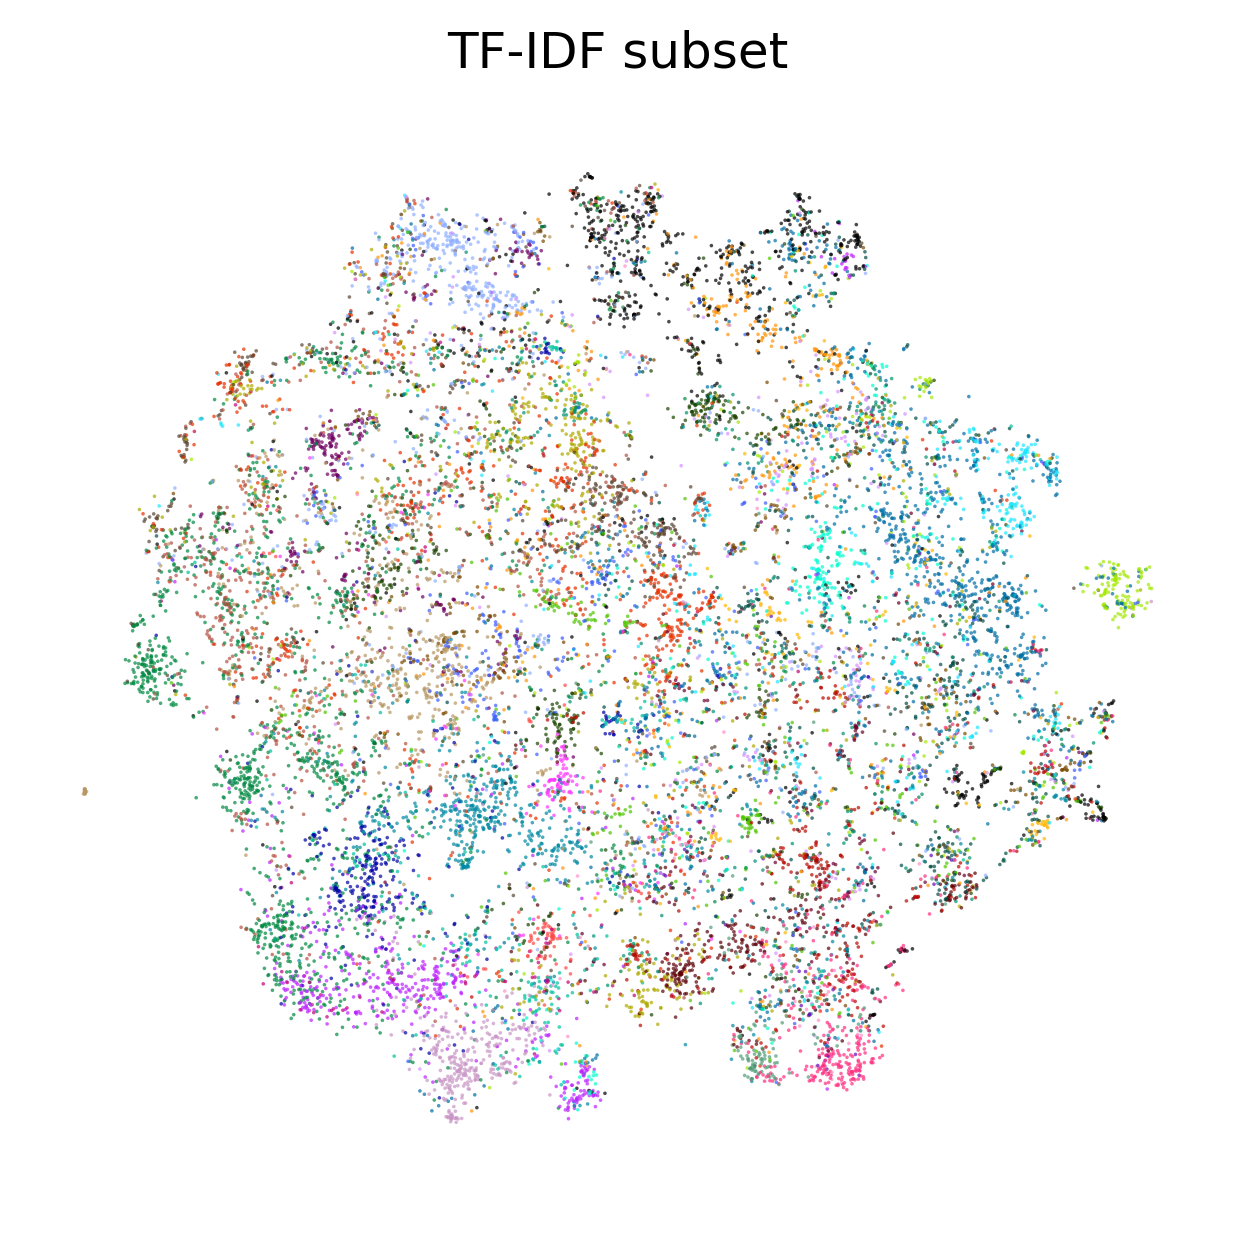

In [45]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 4), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
x_lim = (-230, 230)
y_lim = (-230, 230)


plot_tsne_colors(
    tsne_tfidf_subset,
    colors_subset,
    x_lim=None,
    y_lim=None,
    ax=ax,
    plot_type="test",
)
ax.set_title("TF-IDF subset")

# fig.savefig(figures_path / "fig_1_general_embedding.png", dpi=300)
# fig.savefig(figures_path / "fig_1_general_embedding.pdf", dpi=300)

## Plot BERT

Text(0.5, 1.0, 'BERT subset')

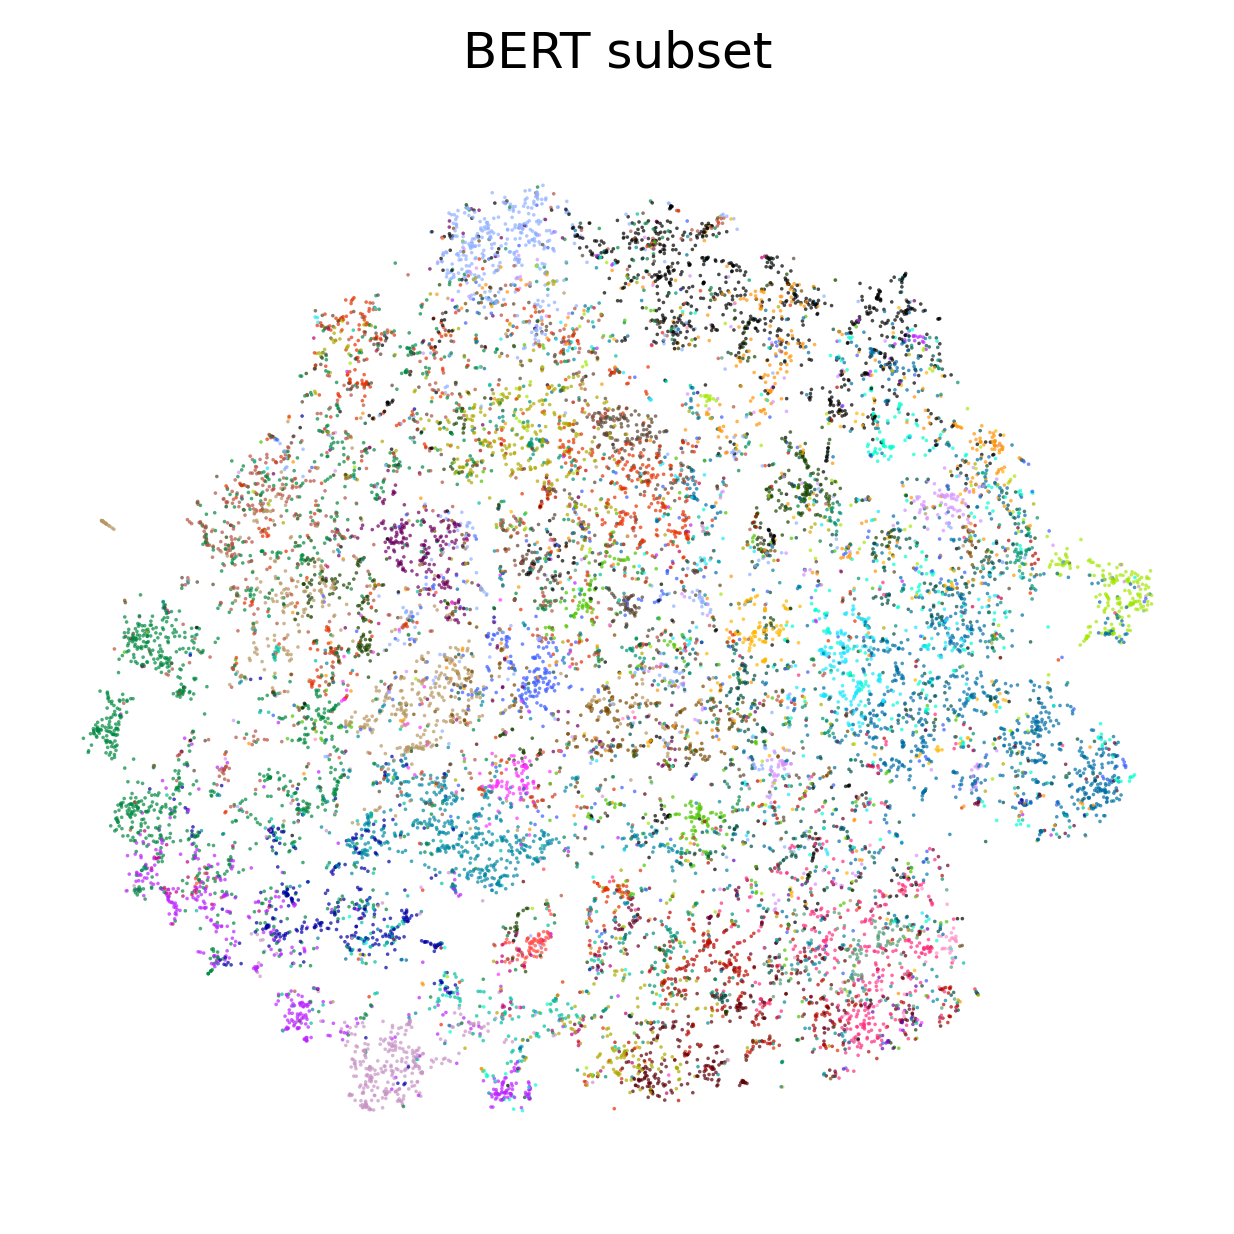

In [53]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(4, 4), dpi=300, layout="constrained")

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")
x_lim = (-230, 230)
y_lim = (-230, 230)

tsne = np.vstack((-tsne_bert_subset[:, 0], tsne_bert_subset[:, 1])).T
plot_tsne_colors(
    tsne,
    colors_subset,
    x_lim=None,
    y_lim=None,
    ax=ax,
    plot_type="test",
)
ax.set_title("BERT subset")

# fig.savefig(figures_path / "fig_1_general_embedding.png", dpi=300)
# fig.savefig(figures_path / "fig_1_general_embedding.pdf", dpi=300)

# kNN accuracy

## Function

In [54]:
from sklearn.neighbors import KNeighborsClassifier


def knn_accuracy(Zs, colors, k=10, subset_size=500, rs=42):
    """Calculates kNN accuracy.
    Calculates the kNN accuracy, for a subset of labeled points (color different than grey), doing a train test split.

    Parameters
    ----------
    Zs : list of array-like
        List with the different datasets for which to calculate the kNN accuracy.
    colors : array-like
        Array with labels (colors).
    k : int, default=10
        Number of nearest neighbors to use.
    subset_size : int, default=500
        Subset size for the kNN calculation
    rs : int, default=42
        Random seed.

    Returns
    -------
    knn_scores : list of floats
        List with the kNN accuracy for the different datasets `Zs`.
    """

    knn_scores = []

    for i, Xrp in enumerate(Zs):
        n = np.sum(colors != "lightgrey")
        np.random.seed(rs)
        test = np.random.choice(n, size=subset_size, replace=False)
        train = np.setdiff1d(np.arange(n), test)

        neigh = KNeighborsClassifier(
            n_neighbors=10, algorithm="brute", n_jobs=-1
        )
        neigh.fit(
            Xrp[colors != "lightgrey"][train],
            colors[colors != "lightgrey"][train],
        )
        acc = np.mean(
            neigh.predict(Xrp[colors != "lightgrey"][test])
            == colors[colors != "lightgrey"][test]
        )
        knn_scores.append(acc)

    return knn_scores

## TF-IDF

In [55]:
tfidf_subset.shape

(16000, 77086)

In [56]:
knn_accuracies_tfidf_subset = knn_accuracy(
    [tfidf_subset, tsne_tfidf_subset],
    colors_subset,
    k=10,
    subset_size=500,
    rs=42,
)

In [57]:
print(knn_accuracies_tfidf_subset)

[0.536, 0.436]


## BERT

In [58]:
knn_accuracies_tfidf_subset = knn_accuracy(
    [embeddings_subset, tsne_bert_subset],
    colors_subset,
    k=10,
    subset_size=500,
    rs=42,
)

In [59]:
print(knn_accuracies_tfidf_subset)

[0.586, 0.53]


# New comparison

## Import

### ICLR

In [187]:
%%time
compression_opts = dict(method="zip", archive_name="iclr.pickle.csv")

iclr = pd.read_pickle(
    data_path / "iclr.pickle.zip",
    # index_col=False,
    compression=compression_opts,
)

CPU times: user 191 ms, sys: 29.5 ms, total: 221 ms
Wall time: 522 ms


In [188]:
iclr

,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,2018,ryBnUWb0b,Predicting Floor-Level for 911 Calls with Neur...,"In cities with tall buildings, emergency respo...","William Falcon, Henning Schulzrinne",Accept (Poster),"[7, 6, 6]","[recurrent neural networks, rnn, lstm, mobile ...",male,None,2.536470,0.739367
1,2018,Skk3Jm96W,Some Considerations on Learning to Explore via...,We consider the problem of exploration in meta...,"Bradly Stadie, Ge Yang, Rein Houthooft, Xi Che...",Invite to Workshop Track,"[7, 4, 6]","[reinforcement learning, rl, exploration, meta...",male,male,49.831927,-29.813831
2,2018,r1RQdCg0W,MACH: Embarrassingly parallel $K$-class classi...,We present Merged-Averaged Classifiers via Has...,"Qixuan Huang, Anshumali Shrivastava, Yiqiu Wang",Reject,"[6, 6, 6]","[extreme classification, large-scale learning,...",None,None,-22.502752,9.577367
3,2018,rJ3fy0k0Z,Deterministic Policy Imitation Gradient Algorithm,The goal of imitation learning (IL) is to enab...,"Fumihiro Sasaki, Atsuo Kawaguchi",Reject,"[6, 5, 5]",[imitation learning],None,None,40.437523,-47.690889
4,2018,SkBYYyZRZ,Searching for Activation Functions,The choice of activation functions in deep net...,"Prajit Ramachandran, Barret Zoph, Quoc V. Le",Invite to Workshop Track,"[5, 4, 7]","[meta learning, activation functions]",None,None,-33.260086,-4.038115
...,...,...,...,...,...,...,...,...,...,...,...,...
16531,2023,w4eQcMZsJa,Text-Driven Generative Domain Adaptation with ...,Combined with the generative prior of pre-trai...,"Zhenhuan Liu, Liang Li, Jiayu Xiao, Zhengjun Z...",Desk rejected,[],"[gan, stylegan, clip, domain adaptation, style...",None,None,59.296526,5.206691
16532,2023,SDHSQuBpf2,"Laziness, Barren Plateau, and Noises in Machin...",We define \emph{laziness} to describe a large ...,"Zexi Lin, Liang Jiang",Desk rejected,[],"[theoretical issues in deep learning, learning...",None,male,-29.178083,-21.810583
16533,2023,HyIY8u5LVDr,Discovering the Representation Bottleneck of G...,Most graph neural networks (GNNs) rely on the ...,"Fang Wu, Siyuan Li, Lirong Wu, Dragomir Radev,...",Desk rejected,[],"[gnn bottleneck, graph rewiring, representatio...",None,male,-7.573978,68.386671
16534,2023,470wZ5Qk4ur,Results for Perfect Classification for Graph A...,We study the ability of one layer Graph Attent...,"Kimon Fountoulakis, Amit Levi",Desk rejected,[],[],None,male,-7.753593,60.764583


In [189]:
titles_abstracts_together = [
    iclr.title[i] + " " + iclr.abstract[i] for i in range(len(iclr))
]

#### Labels

In [190]:
# iclr = pd.read_pickle("iclr.pickle.zip")

keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "translation",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
]
keywords = np.array(keywords)

y = np.zeros(iclr.shape[0]) * np.nan

for num, keyword in enumerate(keywords):
    mask = [keyword.lower() in t.lower() for t in iclr.title]
    y[mask & ~np.isnan(y)] = -1
    y[mask & np.isnan(y)] = num

print(y.size)
print(np.sum(~np.isnan(y)))
print(np.sum(y >= 0))

labeled = y >= 0

iclr_labeled = iclr[labeled].reset_index(drop=True)
y_labeled = y[labeled].astype(int)
iclr_labeled["y"] = y_labeled
iclr_labeled["label"] = keywords[y_labeled]

16536
8964
6849


#### Colors

In [191]:
keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "translation",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
]
keywords = np.array(keywords)

# glasbey.create_palette(palette_size=32)
labelColors = [
    "#d21820",
    "#1869ff",
    "#008a00",
    "#f36dff",
    "#710079",
    "#aafb00",
    "#00bec2",
    "#ffa235",
    "#5d3d04",
    "#08008a",
    "#005d5d",
    "#9a7d82",
    "#a2aeff",
    "#96b675",
    "#9e28ff",
    "#4d0014",
    "#ffaebe",
    "#ce0092",
    "#00ffb6",
    "#002d00",
    "#9e7500",
    "#3d3541",
    "#f3eb92",
    "#65618a",
    "#8a3d4d",
    "#5904ba",
    "#558a71",
    "#b2bec2",
    "#ff5d82",
    "#1cc600",
    "#92f7ff",
    "#2d86a6",
]
labelColors = np.array(labelColors)

dict_colors = dict(zip(keywords, labelColors))

In [192]:
# correct the 3d to 3D for my color creation method
dict_colors["3D"] = dict_colors["3d"]
dict_colors.pop("3d")

'#5904ba'

In [193]:
# change optimization color
dict_colors["optimization"] = "#8b4513"

In [194]:
dict_colors

{'network': '#d21820',
 'graph': '#1869ff',
 'reinforcement': '#008a00',
 'language': '#f36dff',
 'adversarial': '#710079',
 'federated': '#aafb00',
 'contrastive': '#00bec2',
 'domain': '#ffa235',
 'diffusion': '#5d3d04',
 'out-of-dis': '#08008a',
 'continual': '#005d5d',
 'distillation': '#9a7d82',
 'architecture': '#a2aeff',
 'privacy': '#96b675',
 'protein': '#9e28ff',
 'fair': '#4d0014',
 'attention': '#ffaebe',
 'video': '#ce0092',
 'meta-learning': '#00ffb6',
 'generative adv': '#002d00',
 'autoencoder': '#9e7500',
 'game': '#3d3541',
 'semi-sup': '#f3eb92',
 'pruning': '#65618a',
 'physics': '#8a3d4d',
 'translation': '#558a71',
 'optimization': '#8b4513',
 'recurrent': '#ff5d82',
 'word': '#1cc600',
 'bayesian': '#92f7ff',
 '3D': '#5904ba'}

In [195]:
labels_with_unlabeled, colors = improved_coloring(iclr["title"], dict_colors)

### PubMed

In [36]:
# Import
pubmed = pd.read_pickle(
    "/gpfs01/berens/data/data/pubmed_processed/df_labeled_papers_subset"
)
pubmed = pubmed.reset_index(drop=True)
pubmed_colors = pubmed["Colors"].to_numpy()

In [50]:
print(pubmed_colors.shape)
print(np.sum(pubmed_colors == "lightgrey"))

(1000000,)
0


In [14]:
pubmed.head()

,PMID,Title,AbstractText,Language,Journal,Date,filename,Colors
0,18489772,Prevalence of bortezomib-resistant constitutiv...,The proteasome inhibitor bortezomib can inhibi...,eng,Molecular cancer,2008 May 19,pubmed21n0599.xml,black
1,25336168,Visualization of the entire differentiation pr...,The microfold (M) cell residing in the follicl...,eng,Mucosal immunology,2015 May,pubmed21n0810.xml,#8FB0FF
2,24705805,Incisional hernia in recipients of adult to ad...,After receiving a living donor liver transplan...,eng,World journal of surgery,2014 Aug,pubmed21n0790.xml,#006FA6
3,29315767,Benchmark dose analysis framework for developi...,The effects characterization phase of ecologic...,eng,Environmental toxicology and chemistry,2018 05,pubmed21n0932.xml,#0089A3
4,26505957,Impact of OAS1 Exon 7 rs10774671 Genetic Varia...,The aim of this study was to assess the impact...,eng,Viral immunology,2015 Nov,pubmed21n0846.xml,#8FB0FF


In [39]:
# legend colors
pickle_in = open(
    "../../pubmed-landscape/results/variables/colors_new_legend.pkl", "rb"
)
colors_new_legend = pickle.load(pickle_in)

#### Subset

In [40]:
# select subset for training of the same size as iclr
print(iclr.abstract.shape)
np.random.seed(42)
subset = np.random.choice(
    pubmed.AbstractText.shape[0], size=iclr.abstract.shape[0], replace=False
)
pubmed_abstracts_subset = pubmed.AbstractText.iloc[subset]
pubmed_colors_subset = pubmed_colors[subset]
print(pubmed_abstracts_subset.shape)
print(type(pubmed_abstracts_subset))
print(type(iclr.abstract))

(16536,)
(16536,)
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


## Class distribution

### ICLR

In [196]:
unique_colors_iclr, counts_colors_iclr = np.unique(colors, return_counts=True)

In [203]:
len(unique_colors_iclr[:-1])
unique_colors_iclr[-1]

'lightgrey'

In [198]:
fraction_colors_iclr = counts_colors_iclr[:-1] / np.sum(
    counts_colors_iclr[:-1]
)

In [199]:
# define vocabulary swap
new_colors_legend_swap = {value: key for key, value in dict_colors.items()}

In [200]:
unique_labels = np.vectorize(new_colors_legend_swap.get)(unique_colors_iclr)
unique_labels = np.where(
    unique_colors_iclr == "lightgrey", "unlabeled", unique_labels
)

In [201]:
dict(zip(unique_labels, fraction_colors_iclr * 100))

{'generative adv': 0.08295804693055227,
 'continual': 2.1450580706328513,
 'reinforcement': 9.670538042190092,
 'contrastive': 2.950936240815359,
 'meta-learning': 0.30812988859919416,
 'out-of-dis': 0.4977482815833135,
 'graph': 9.07798056411472,
 'word': 0.9599431144821048,
 'game': 1.4102867978193885,
 'fair': 1.4576913960654183,
 'translation': 1.8487793315951646,
 '3D': 2.1450580706328513,
 'diffusion': 1.5643517421189856,
 'pruning': 1.6710120881725528,
 'adversarial': 8.710594927707987,
 'physics': 0.8532827684285377,
 'optimization': 5.878170182507703,
 'bayesian': 1.9791419767717466,
 'privacy': 1.1021569092201944,
 'distillation': 1.73026783598009,
 'protein': 0.6162597771983883,
 'autoencoder': 2.2161649680018964,
 'architecture': 2.7257643991467173,
 'federated': 3.0101919886228963,
 'video': 1.9435885280872245,
 'network': 18.464091016828633,
 'language': 4.764162123726001,
 'semi-sup': 0.865133917990045,
 'recurrent': 1.9435885280872245,
 'domain': 3.887177056174449,
 'at

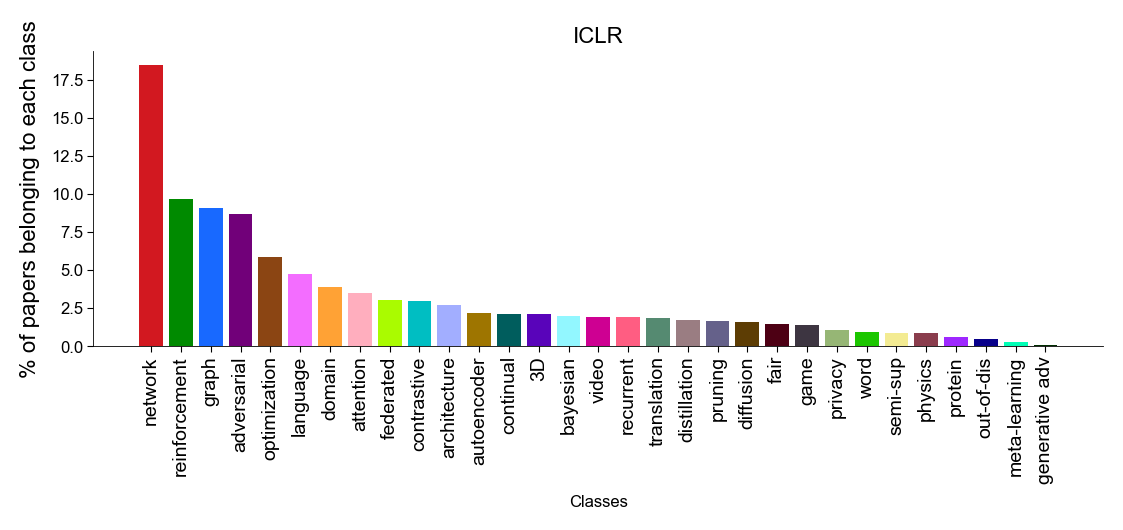

In [77]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5.5, 2.5), dpi=200)
ax.bar(
    np.arange(len(fraction_colors_iclr)),
    np.flip(np.sort(fraction_colors_iclr * 100)),
    color=unique_colors_iclr[:-1][
        np.flip(np.argsort(fraction_colors_iclr * 100))
    ],
)

ax.set_xticks(
    np.arange(len(fraction_colors_iclr)),
    labels=unique_labels[:-1][np.flip(np.argsort(fraction_colors_iclr * 100))],
    rotation="vertical",
    fontsize=7,
)
ax.set_ylabel("% of papers belonging to each class", fontsize=8)
ax.set_xlabel("Classes")
ax.set_title("ICLR")


fig.savefig(figures_path / "barplot_class_distribution_iclr.png")

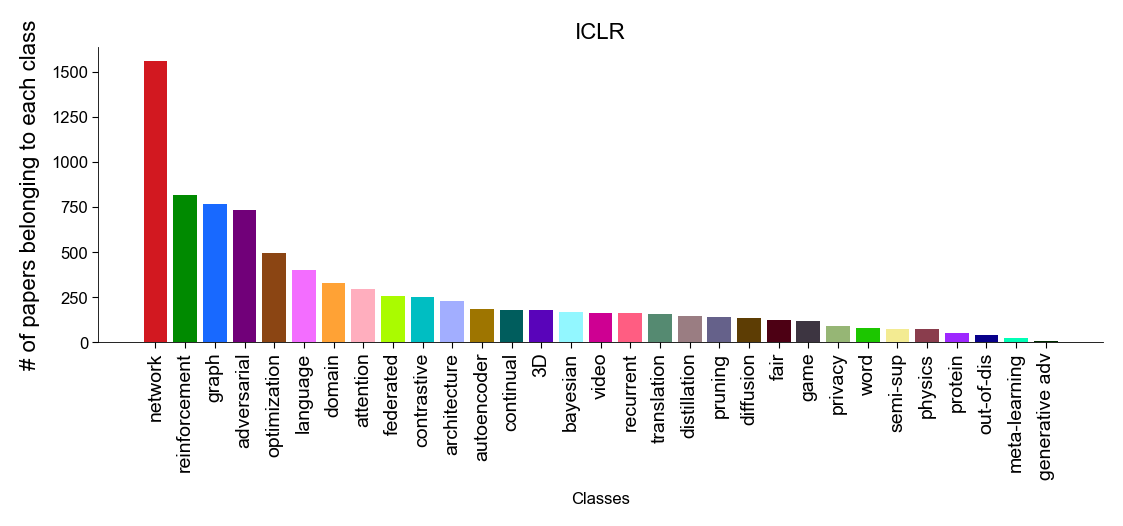

In [205]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5.5, 2.5), dpi=200)
ax.bar(
    np.arange(len(counts_colors_iclr[:-1])),
    np.flip(np.sort(counts_colors_iclr[:-1])),
    color=unique_colors_iclr[:-1][
        np.flip(np.argsort(counts_colors_iclr[:-1]))
    ],
)

ax.set_xticks(
    np.arange(len(counts_colors_iclr[:-1])),
    labels=unique_labels[:-1][np.flip(np.argsort(counts_colors_iclr[:-1]))],
    rotation="vertical",
    fontsize=7,
)
ax.set_ylabel("# of papers belonging to each class", fontsize=8)
ax.set_xlabel("Classes")
ax.set_title("ICLR")


fig.savefig(figures_path / "barplot_class_distribution_iclr_counts.png")

### PubMed subset

In [99]:
unique_colors_pubmed_subset, counts_colors_pubmed_subset = np.unique(
    pubmed_colors_subset, return_counts=True
)

In [132]:
len(unique_colors_pubmed_subset)

38

In [102]:
fraction_colors_pubmed_subset = counts_colors_pubmed_subset / np.sum(
    counts_colors_pubmed_subset
)

In [103]:
# define vocabulary swap
new_colors_legend_swap = {
    value: key for key, value in colors_new_legend.items()
}

In [106]:
unique_labels = np.vectorize(new_colors_legend_swap.get)(
    unique_colors_pubmed_subset
)
unique_labels = np.where(
    unique_colors_pubmed_subset == "lightgrey", "unlabeled", unique_labels
)

In [108]:
dict(zip(unique_labels, fraction_colors_pubmed_subset * 100))

{'material': 2.3524431543299467,
 'pediatric': 3.483309143686502,
 'surgery': 8.145863570391871,
 'chemistry': 8.980406386066765,
 'environment': 4.940735365263667,
 'neurology': 2.5459603289791968,
 'engineering': 1.7779390420899857,
 'radiology': 1.8263183357522979,
 'genetics': 2.6910982099661345,
 'cardiology': 2.1770682148040637,
 'veterinary': 2.2375423318819547,
 'nutrition': 2.279874213836478,
 'education': 1.0522496371552976,
 'psychology': 1.9533139816158684,
 'pharmacology': 3.586115142718916,
 'ethics': 0.22375423318819546,
 'rehabilitation': 1.022012578616352,
 'virology': 1.7839864537977745,
 'infectious': 1.6569908079342042,
 'immunology': 4.233188195452346,
 'ophthalmology': 2.080309627479439,
 'microbiology': 4.178761490082245,
 'psychiatry': 2.418964683115626,
 'physics': 3.138606676342525,
 'computation': 0.42331881954523465,
 'optics': 1.8384131591678763,
 'anesthesiology': 0.24794388001935175,
 'dermatology': 1.3546202225447508,
 'physiology': 4.499274310595065,
 '

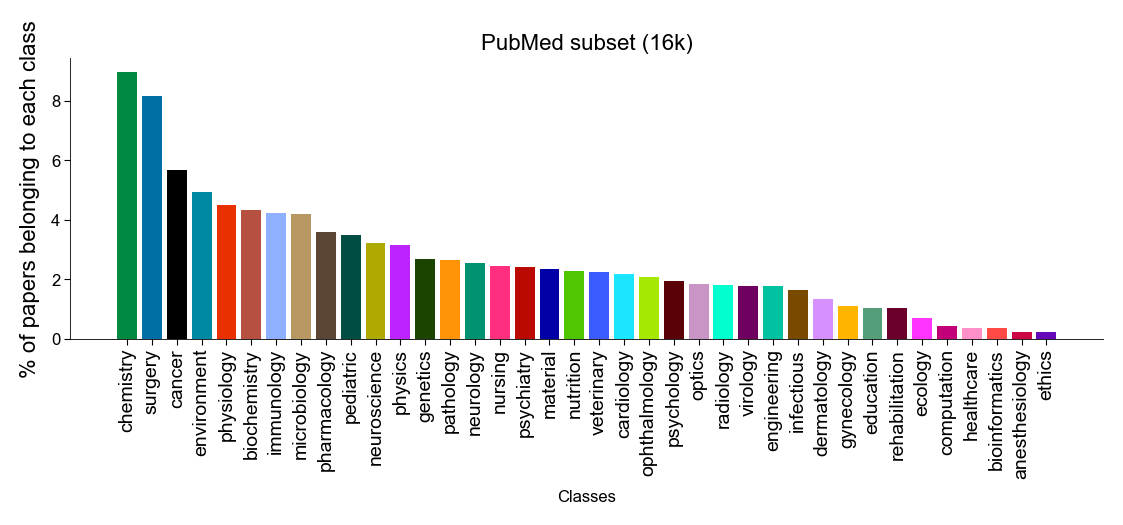

In [110]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5.5, 2.5), dpi=200)
ax.bar(
    np.arange(len(fraction_colors_pubmed_subset)),
    np.flip(np.sort(fraction_colors_pubmed_subset * 100)),
    color=unique_colors_pubmed_subset[
        np.flip(np.argsort(fraction_colors_pubmed_subset * 100))
    ],
)

ax.set_xticks(
    np.arange(len(fraction_colors_pubmed_subset)),
    labels=unique_labels[
        np.flip(np.argsort(fraction_colors_pubmed_subset * 100))
    ],
    rotation="vertical",
    fontsize=7,
)
ax.set_ylabel("% of papers belonging to each class", fontsize=8)
ax.set_xlabel("Classes")
ax.set_title("PubMed subset (16k)")


fig.savefig(figures_path / "barplot_class_distribution_pubmed_subset_size_labeled.png")

### PubMed subset (size subset labeled)

In [206]:
# select subset for training of the same size as iclr
print(iclr.abstract.shape)
np.random.seed(42)
mask_subset_eval = np.random.choice(
    iclr.abstract.shape[0], size=iclr.abstract[labeled].shape[0], replace=False
)
print(iclr.abstract[labeled].shape[0])
print(mask_subset_eval.shape[0])

(16536,)
6849
6849


In [207]:
unique_colors_pubmed_subset_2, counts_colors_pubmed_subset_2 = np.unique(
    pubmed_colors_subset[mask_subset_eval], return_counts=True
)

In [208]:
len(unique_colors_pubmed_subset_2)

38

In [209]:
fraction_colors_pubmed_subset_2 = counts_colors_pubmed_subset_2 / np.sum(
    counts_colors_pubmed_subset_2
)

In [210]:
# define vocabulary swap
new_colors_legend_swap = {
    value: key for key, value in colors_new_legend.items()
}

In [211]:
unique_labels = np.vectorize(new_colors_legend_swap.get)(
    unique_colors_pubmed_subset_2
)
unique_labels = np.where(
    unique_colors_pubmed_subset_2 == "lightgrey", "unlabeled", unique_labels
)

In [212]:
dict(zip(unique_labels, fraction_colors_pubmed_subset_2 * 100))

{'material': 2.3215067893123087,
 'pediatric': 3.7085705942473353,
 'surgery': 7.665352606219885,
 'chemistry': 9.213023799094758,
 'environment': 4.876624324718938,
 'neurology': 2.5843188786684186,
 'engineering': 1.7374799240765075,
 'radiology': 1.8250839538618775,
 'genetics': 2.5259161921448383,
 'cardiology': 2.3507081325740984,
 'veterinary': 2.2923054460505186,
 'nutrition': 2.2485034311578334,
 'education': 1.0512483574244416,
 'psychology': 2.1462987297415683,
 'pharmacology': 3.5041611914148048,
 'ethics': 0.3066141042487955,
 'rehabilitation': 1.1826544021024967,
 'virology': 1.8250839538618775,
 'infectious': 1.7082785808147174,
 'immunology': 3.956782011972551,
 'ophthalmology': 1.971090670170828,
 'microbiology': 4.3656008176376115,
 'psychiatry': 2.3945101474667836,
 'physics': 3.2705504453204846,
 'computation': 0.40881880566506057,
 'optics': 1.6644765659220324,
 'anesthesiology': 0.2190100744634253,
 'dermatology': 1.328661118411447,
 'physiology': 4.307198131114031

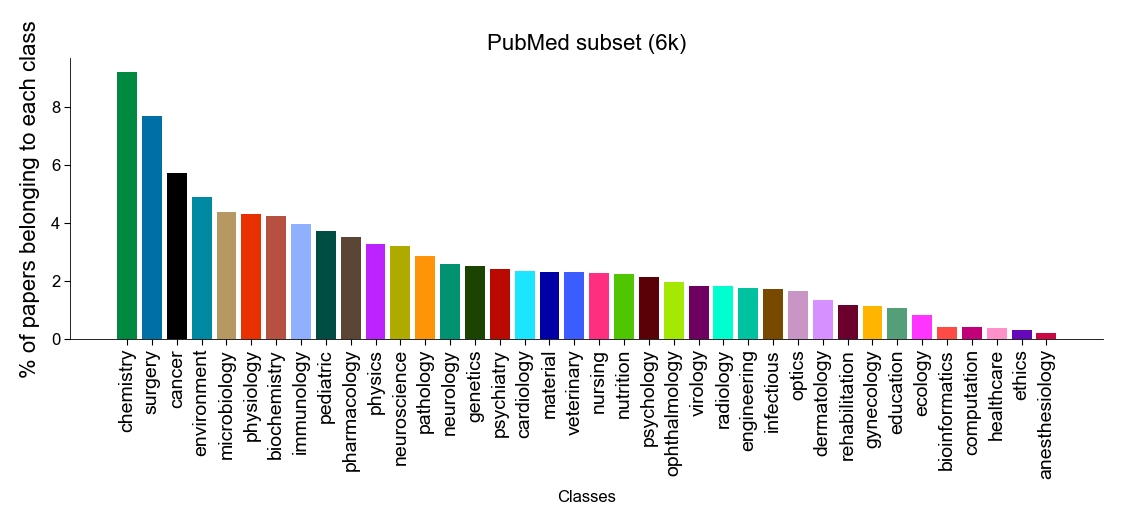

In [151]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5.5, 2.5), dpi=200)
ax.bar(
    np.arange(len(fraction_colors_pubmed_subset_2)),
    np.flip(np.sort(fraction_colors_pubmed_subset_2 * 100)),
    color=unique_colors_pubmed_subset_2[
        np.flip(np.argsort(fraction_colors_pubmed_subset_2 * 100))
    ],
)

ax.set_xticks(
    np.arange(len(fraction_colors_pubmed_subset_2)),
    labels=unique_labels[
        np.flip(np.argsort(fraction_colors_pubmed_subset_2 * 100))
    ],
    rotation="vertical",
    fontsize=7,
)
ax.set_ylabel("% of papers belonging to each class", fontsize=8)
ax.set_xlabel("Classes")
ax.set_title("PubMed subset (6k)")


fig.savefig(
    figures_path / "barplot_class_distribution_pubmed_subset_size_labeled.png"
)

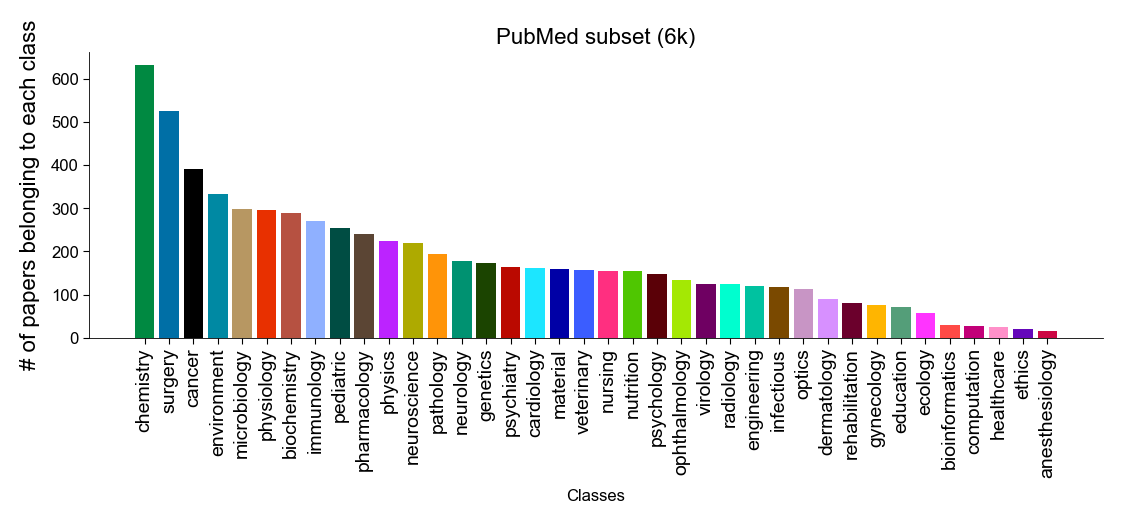

In [213]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5.5, 2.5), dpi=200)
ax.bar(
    np.arange(len(counts_colors_pubmed_subset_2)),
    np.flip(np.sort(counts_colors_pubmed_subset_2)),
    color=unique_colors_pubmed_subset_2[
        np.flip(np.argsort(counts_colors_pubmed_subset_2))
    ],
)

ax.set_xticks(
    np.arange(len(counts_colors_pubmed_subset_2)),
    labels=unique_labels[np.flip(np.argsort(counts_colors_pubmed_subset_2))],
    rotation="vertical",
    fontsize=7,
)
ax.set_ylabel("# of papers belonging to each class", fontsize=8)
ax.set_xlabel("Classes")
ax.set_title("PubMed subset (6k)")


fig.savefig(
    figures_path
    / "barplot_class_distribution_pubmed_subset_size_labeled_counts.png"
)

### PubMed full

In [155]:
colors_new = np.load(
    "../../pubmed-landscape/results/variables/colors_new.npy",
    allow_pickle=True,
)

In [156]:
unique_colors_pubmed, counts_colors_pubmed = np.unique(
    colors_new, return_counts=True
)

In [157]:
len(unique_colors_pubmed)

39

In [158]:
fraction_colors_pubmed = counts_colors_pubmed[:-1] / np.sum(
    counts_colors_pubmed[:-1]
)

In [159]:
# define vocabulary swap
new_colors_legend_swap = {
    value: key for key, value in colors_new_legend.items()
}

In [160]:
unique_labels = np.vectorize(new_colors_legend_swap.get)(unique_colors_pubmed)
unique_labels = np.where(
    unique_colors_pubmed == "lightgrey", "unlabeled", unique_labels
)

In [161]:
dict(zip(unique_labels, fraction_colors_pubmed * 100))

{'material': 2.130520265715626,
 'pediatric': 3.403397052040048,
 'surgery': 7.6325721471380215,
 'chemistry': 8.978767512303287,
 'environment': 4.9043012162489585,
 'neurology': 2.5706703785922667,
 'engineering': 1.7664822214729246,
 'radiology': 1.880636286786681,
 'genetics': 2.914297698417088,
 'cardiology': 1.9778048111474562,
 'veterinary': 2.2079378346046283,
 'nutrition': 2.2195609981658424,
 'education': 1.008140987289481,
 'psychology': 1.9011452746646198,
 'pharmacology': 3.9593155585028357,
 'ethics': 0.2058900240970079,
 'rehabilitation': 1.041480375523639,
 'virology': 1.5835437341181682,
 'infectious': 1.8639876491253289,
 'immunology': 4.095943880895702,
 'ophthalmology': 2.0271892186454634,
 'microbiology': 3.924488180730648,
 'psychiatry': 2.3641767360977557,
 'physics': 3.0156634762860794,
 'computation': 0.5803580327430694,
 'optics': 2.1074704655133156,
 'anesthesiology': 0.2535478022254147,
 'dermatology': 1.520346291663356,
 'physiology': 4.4122679964613924,
 '

Text(0.5, 1.0, 'PubMed full')

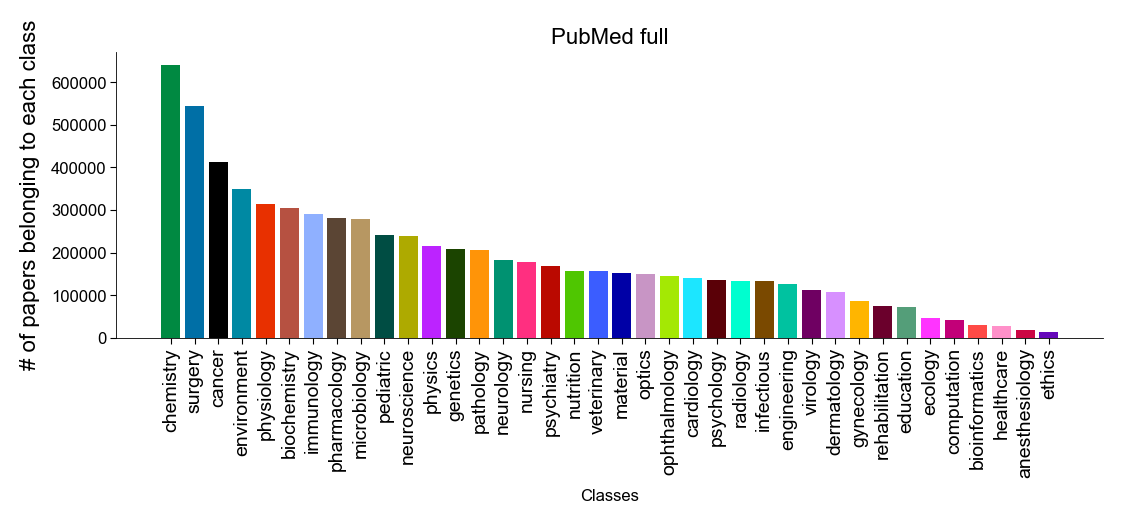

In [163]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5.5, 2.5), dpi=200)
ax.bar(
    np.arange(len(counts_colors_pubmed[:-1])),
    np.flip(np.sort(counts_colors_pubmed[:-1])),
    color=unique_colors_pubmed[:-1][
        np.flip(np.argsort(counts_colors_pubmed[:-1]))
    ],
)

ax.set_xticks(
    np.arange(len(counts_colors_pubmed[:-1])),
    labels=unique_labels[:-1][np.flip(np.argsort(counts_colors_pubmed[:-1]))],
    rotation="vertical",
    fontsize=7,
)
ax.set_ylabel("# of papers belonging to each class", fontsize=8)
ax.set_xlabel("Classes")
ax.set_title("PubMed full")


# fig.savefig(figures_path / "barplot_class_distribution_pubmed.png")

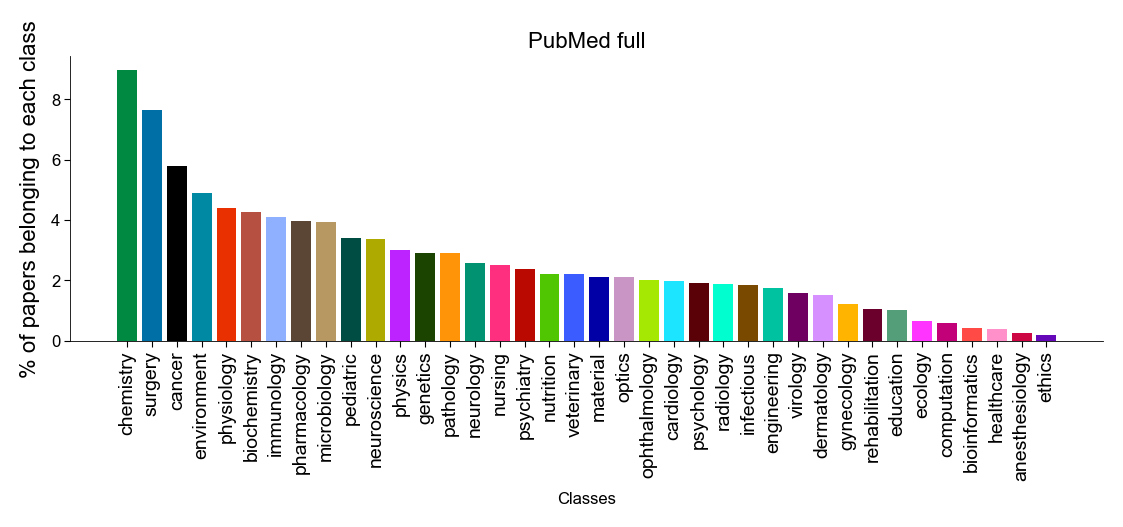

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5.5, 2.5), dpi=200)
ax.bar(
    np.arange(len(fraction_colors_pubmed)),
    np.flip(np.sort(fraction_colors_pubmed * 100)),
    color=unique_colors_pubmed[:-1][
        np.flip(np.argsort(fraction_colors_pubmed * 100))
    ],
)

ax.set_xticks(
    np.arange(len(fraction_colors_pubmed)),
    labels=unique_labels[:-1][
        np.flip(np.argsort(fraction_colors_pubmed * 100))
    ],
    rotation="vertical",
    fontsize=7,
)
ax.set_ylabel("% of papers belonging to each class", fontsize=8)
ax.set_xlabel("Classes")
ax.set_title("PubMed full")


fig.savefig(figures_path / "barplot_class_distribution_pubmed.png")

## ICLR new data

In [123]:
%%time
compression_opts = dict(method="zip", archive_name="iclr.pickle.csv")

iclr2024 = pd.read_pickle(
    data_path / "iclr2024.pickle.zip",
    # index_col=False,
    compression=compression_opts,
)

CPU times: user 460 ms, sys: 31.6 ms, total: 491 ms
Wall time: 501 ms


In [125]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",NaN,NaN,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",NaN,NaN,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",NaN,NaN,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],NaN,NaN,-11.437999,21.289523


In [126]:
titles_abstracts_together = [
    iclr2024.title[i] + " " + iclr2024.abstract[i] for i in range(len(iclr))
]

In [128]:
keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
    "causal",
    "time series",
    "backdoor",
    "anomaly",
    "object-",
    "multi-agent",
    "offline reinf",
    "imitation",
    "bandit",
    "reasoning",
    "question",
    "vision-lang",
    "audio",
]

keywords = np.array(keywords)
print(f"There are {len(keywords)} labels")

y = np.zeros(iclr2024.shape[0]) * np.nan

for num, keyword in enumerate(keywords):
    mask = [keyword.lower() in t.lower() for t in iclr2024.title]
    y[mask & ~np.isnan(y)] = -1
    y[mask & np.isnan(y)] = num

print(y.size)
print(np.sum(~np.isnan(y)))
print(np.sum(y >= 0))

labeled = y >= 0

iclr_labeled = iclr2024[labeled].reset_index(drop=True)
y_labeled = y[labeled].astype(int)
iclr_labeled["y"] = y_labeled
iclr_labeled["label"] = keywords[y_labeled]

There are 43 labels
24347
14152
10235


#### Colors

In [131]:
len(labelColors)

32

In [164]:
keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
    "causal",
    "time series",
    "backdoor",
    "anomaly",
    "object-",
    "multi-agent",
    "offline reinf",
    "imitation",
    "bandit",
    "reasoning",
    "question",
    "vision-lang",
    "audio",
]

keywords = np.array(keywords)

labelColors = [
    "#d21820",
    "#1869ff",
    "#008a00",
    "#f36dff",
    "#710079",
    "#aafb00",
    "#00bec2",
    "#ffa235",
    "#5d3d04",
    "#08008a",
    "#005d5d",
    "#9a7d82",
    "#a2aeff",
    "#96b675",
    "#9e28ff",
    "#4d0014",
    "#ffaebe",
    "#ce0092",
    "#00ffb6",
    "#002d00",
    "#9e7500",
    "#3d3541",
    "#f3eb92",
    "#65618a",
    "#8a3d4d",
    "#5904ba",
    "#558a71",
    "#b2bec2",
    "#ff5d82",
    "#1cc600",
    "#92f7ff",
    "#2d86a6",
    "#395d28",
    "#ebceff",
    "#ff5d00",
    "#a661aa",
    "#860000",
    "#350059",
    "#00518e",
    "#9e4910",
    "#cebe00",
    "#002828",
    "#00b2ff",
    "#caa686",
    "#be9ac2",
    "#2d200c",
    "#756545",
    "#8279df",
    "#00c28a",
    "#bae7c2",
]

labelColors = np.array(labelColors)

dict_colors = dict(zip(keywords, labelColors))

In [165]:
dict_colors

{'network': '#d21820',
 'graph': '#1869ff',
 'reinforcement': '#008a00',
 'language': '#f36dff',
 'adversarial': '#710079',
 'federated': '#aafb00',
 'contrastive': '#00bec2',
 'domain': '#ffa235',
 'diffusion': '#5d3d04',
 'out-of-dis': '#08008a',
 'continual': '#005d5d',
 'distillation': '#9a7d82',
 'architecture': '#a2aeff',
 'privacy': '#96b675',
 'protein': '#9e28ff',
 'fair': '#4d0014',
 'attention': '#ffaebe',
 'video': '#ce0092',
 'meta-learning': '#00ffb6',
 'generative adv': '#002d00',
 'autoencoder': '#9e7500',
 'game': '#3d3541',
 'semi-sup': '#f3eb92',
 'pruning': '#65618a',
 'physics': '#8a3d4d',
 '3d': '#5904ba',
 'optimization': '#558a71',
 'recurrent': '#b2bec2',
 'word': '#ff5d82',
 'bayesian': '#1cc600',
 'causal': '#92f7ff',
 'time series': '#2d86a6',
 'backdoor': '#395d28',
 'anomaly': '#ebceff',
 'object-': '#ff5d00',
 'multi-agent': '#a661aa',
 'offline reinf': '#860000',
 'imitation': '#350059',
 'bandit': '#00518e',
 'reasoning': '#9e4910',
 'question': '#cebe0

In [166]:
labels_with_unlabeled, colors = improved_coloring(
    iclr2024["title"], dict_colors
)

In [167]:
unique_colors_iclr, counts_colors_iclr = np.unique(colors, return_counts=True)

In [168]:
len(unique_colors_iclr[:-1])

43

In [169]:
fraction_colors_iclr = counts_colors_iclr[:-1] / np.sum(
    counts_colors_iclr[:-1]
)

In [170]:
# define vocabulary swap
new_colors_legend_swap = {value: key for key, value in dict_colors.items()}

In [171]:
unique_labels = np.vectorize(new_colors_legend_swap.get)(unique_colors_iclr)
unique_labels = np.where(
    unique_colors_iclr == "lightgrey", "unlabeled", unique_labels
)

In [172]:
dict(zip(unique_labels, fraction_colors_iclr * 100))

{'vision-lang': 0.03841130828916033,
 'generative adv': 0.046093569946992395,
 'bandit': 0.806637474072367,
 'continual': 2.112621955903818,
 'reinforcement': 8.097103787354998,
 'audio': 0.6760390258892218,
 'contrastive': 2.60428670200507,
 'meta-learning': 0.20742106476146577,
 'out-of-dis': 0.4225243911807636,
 'graph': 8.212337712222478,
 'bayesian': 1.8053314895905355,
 'time series': 0.10755166320964892,
 'imitation': 1.1216102020434815,
 'backdoor': 0.9526004455711761,
 'game': 1.3367135284627794,
 'fair': 1.5594991165399092,
 'optimization': 5.231620188983637,
 '3d': 0.007682261657832066,
 'diffusion': 3.9333179688100177,
 'pruning': 1.5441345932242452,
 'adversarial': 6.6605208573404004,
 'offline reinf': 0.030729046631328263,
 'physics': 0.8834600906506876,
 'causal': 1.89751862948452,
 'privacy': 1.0524698471229932,
 'distillation': 1.882154106168856,
 'protein': 0.8373665207036952,
 'reasoning': 1.851425059537528,
 'autoencoder': 1.8053314895905355,
 'architecture': 2.2509

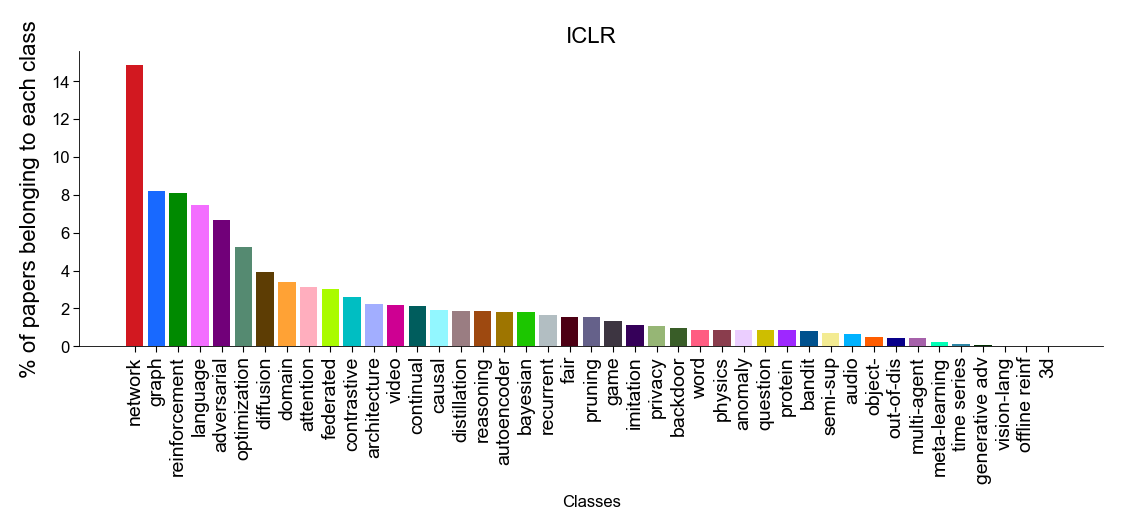

In [173]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5.5, 2.5), dpi=200)
ax.bar(
    np.arange(len(fraction_colors_iclr)),
    np.flip(np.sort(fraction_colors_iclr * 100)),
    color=unique_colors_iclr[:-1][
        np.flip(np.argsort(fraction_colors_iclr * 100))
    ],
)

ax.set_xticks(
    np.arange(len(fraction_colors_iclr)),
    labels=unique_labels[:-1][np.flip(np.argsort(fraction_colors_iclr * 100))],
    rotation="vertical",
    fontsize=7,
)
ax.set_ylabel("% of papers belonging to each class", fontsize=8)
ax.set_xlabel("Classes")
ax.set_title("ICLR")


fig.savefig(figures_path / "barplot_class_distribution_iclr_2024.png")